# Faulty Output Dataset

## Imports

In [2]:
# Dataloader
from fod_data_loader import get_fod_dataset

# Color Pallete
from utils import get_color_pallete, load_faults, filter_faults, cityscapes_labels_dict

# Dataset statistics visualization
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import VBox, interactive_output

In [9]:
fod_dataset = get_fod_dataset('FOD', root='./faulty_output_dataset')

Found 68001 masks in the folder ./faulty_output_dataset


In [10]:
n = len(fod_dataset)
print(n)

68001


## FOD entry example

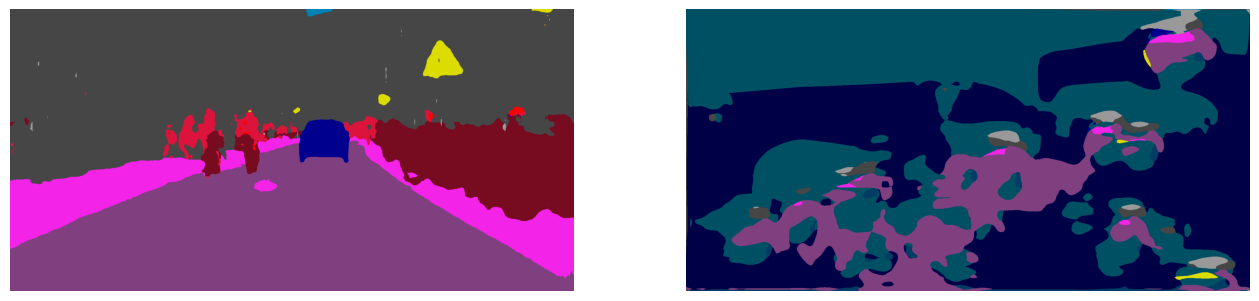

In [11]:
frame, fault, mIoU, pa, cmask, fmask, label = fod_dataset[3]

fig = plt.figure(figsize=(16, 32))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(get_color_pallete(cmask.cpu().numpy()))
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(get_color_pallete(fmask.cpu().numpy()))
plt.axis('off')
plt.show()

## CSV data

In [12]:
df = pd.read_csv('./faulty_output_dataset/faulty_output_dataset.csv')
labels = df['Label'].astype(int)
ids = df[['Frame', 'Injection']]
masks_ids = ids

In [ ]:
# def compute_class_frequencies(mask):
#     frequencies = np.bincount(mask.ravel(), minlength=19)
#     return frequencies / mask.size

# def compute_spatial_distribution(mask, grid_size=(4, 4)):
#     h, w = mask.shape
#     grid_h, grid_w = h // grid_size[0], w // grid_size[1]
#     spatial_stats = []
#     for i in range(grid_size[0]):
#         for j in range(grid_size[1]):
#             sub_mask = mask[i * grid_h:(i + 1) * grid_h, j * grid_w:(j + 1) * grid_w]
#             frequencies = np.bincount(sub_mask.ravel(), minlength=20)
#             spatial_stats.append(frequencies / sub_mask.size)
#     return np.concatenate(spatial_stats)

# from scipy.ndimage import label as lbl

# def compute_complexity(mask):
#     labeled, num_features = lbl(mask)
#     return num_features

# Dataset Statistics

## Critical/NON Critical percentages

In [13]:
total = len(labels)
percent_0 = (labels == 0).sum() / total * 100
percent_1 = (labels == 1).sum() / total * 100
percent_other = 100 - (percent_0 + percent_1)

print(f"Percentuale di NON Critici: {percent_0:.2f}%")
print(f"Percentuale di Critici: {percent_1:.2f}%")
print(f"Percentuale di valori ERRORE: {percent_other:.2f}%")

Percentuale di NON Critici: 11.90%
Percentuale di Critici: 88.10%
Percentuale di valori ERRORE: 0.00%


In [14]:
faults = load_faults("./faulty_output_dataset/Fast-SCNN_38_fault_list_30_3.csv")
filtered_faults = filter_faults(faults, bit=30)
print(faults[0])
print(filtered_faults[0])

{'injection': 0, 'layer_name': 'learning_to_downsample.conv.conv.0', 'tensor_index': (26, 1, 2, 0), 'bit': 30}
{'injection': 0, 'layer_name': 'learning_to_downsample.conv.conv.0', 'tensor_index': (26, 1, 2, 0), 'bit': 30}


In [15]:
frame_ids = df['Frame']
unique_frame_ids = set(frame_ids)
if len(unique_frame_ids):
    print("All Frames from Cityscapes Validation Partition are present in the FOD (Frame column).")
else:
    print("NOT All Frames from Cityscapes Validation Partition are present in the FOD (Frame column).")

All Frames from Cityscapes Validation Partition are present in the FOD (Frame column).


In [16]:
fault_ids = df['Injection']
unique_fault_ids = set(fault_ids)
filtered_fault_ids = set(filtered_faults.keys())
all_ids_present = filtered_fault_ids.issubset(unique_fault_ids)
if all_ids_present:
    print("All 30 bit Injections in the dictionary are present in the FOD (Injection column).")
else:
    print("NOT All 30 bit Injections in the dictionary are present in the FOD (Injection column).")
    missing_ids = filtered_fault_ids - unique_fault_ids
    print("Missing Injections:", missing_ids)

All 30 bit Injections in the dictionary are present in the FOD (Injection column).


In [17]:
# frame_id = 0
# fault_id = 0
# frame, fault, mIoU, pa, cmask, fmask, label = fod_dataset[67990]
# # Calcolo delle feature
# fmask = fmask.cpu().numpy().astype(np.int64)
# freq = compute_class_frequencies(fmask)
# complexity = compute_complexity(fmask)
# feature_vector = np.concatenate([freq, [complexity]])
# print(feature_vector.shape)


## Clustering
Grouping by dominant classes. Basing on how many classes are present in the faulty mask (1° grouping), we group by dominant (highest areas) classes. If more than 3 classes are present, we consider only the top 3.

In [18]:
import numpy as np
from collections import defaultdict

features = np.load('./faulty_output_dataset/area.npy')
freq = features[:, :19]
clusters = defaultdict(list)

for idx, row in enumerate(freq):
    non_zero_count = np.count_nonzero(row)
    clusters[non_zero_count].append(idx)

def estrai_indici(vettore):
    indici_frequenze = []
    for row in vettore:
        non_zero_indices = np.where(row > 0)[0]
        if len(non_zero_indices) == 1:
            # Se c'è solo una frequenza maggiore di 0, prendi l'indice
            indici_frequenze.append([non_zero_indices[0]])
        elif len(non_zero_indices) == 2:
            # Se ce ne sono due, prendi gli indici delle due frequenze
            indici_frequenze.append(non_zero_indices.tolist())
        elif len(non_zero_indices) == 3:
            # Se ce ne sono tre, prendi gli indici delle tre frequenze
            indici_frequenze.append(non_zero_indices.tolist())
        else:
            # Se ci sono più di tre, prendi i primi tre indici con le frequenze più alte
            sorted_indices = np.argsort(-row[non_zero_indices])[:3]  # Indici delle 3 frequenze maggiori
            indici_frequenze.append(non_zero_indices[sorted_indices].tolist())
    return indici_frequenze

result = estrai_indici(freq)
top_3_tuples = [tuple(row) for row in result] #[tuple(sorted(row)) for row in result]
clusters_freq = defaultdict(list)

for non_zero_count, indices in clusters.items():
    for idx in indices:
        top_classes_subset = tuple(top_3_tuples[idx][:non_zero_count])
        clusters_freq[(non_zero_count, top_classes_subset)].append(idx)

clusters_freq = dict(sorted(clusters_freq.items()))

for k, v in clusters_freq.items():
    print(f"Cluster with {k[0]} non-zero elements of classes {[cityscapes_labels_dict[i]['name'] for i in k[1]]}: {len(v)} masks")


Cluster with 1 non-zero elements of classes ['road']: 29152 masks
Cluster with 1 non-zero elements of classes ['sidewalk']: 23 masks
Cluster with 1 non-zero elements of classes ['building']: 12 masks
Cluster with 1 non-zero elements of classes ['wall']: 12 masks
Cluster with 1 non-zero elements of classes ['fence']: 9 masks
Cluster with 1 non-zero elements of classes ['traffic light']: 10 masks
Cluster with 1 non-zero elements of classes ['traffic sign']: 17 masks
Cluster with 1 non-zero elements of classes ['vegetation']: 9 masks
Cluster with 1 non-zero elements of classes ['sky']: 8 masks
Cluster with 1 non-zero elements of classes ['car']: 2 masks
Cluster with 1 non-zero elements of classes ['bus']: 8 masks
Cluster with 1 non-zero elements of classes ['train']: 20 masks
Cluster with 1 non-zero elements of classes ['motorcycle']: 7 masks
Cluster with 2 non-zero elements of classes ['road', 'sidewalk']: 204 masks
Cluster with 2 non-zero elements of classes ['road', 'building']: 47 mas

Masks with the same class for all the pixels:

In [19]:
cnt = 0
for k, v in clusters_freq.items():
  if k[0] == 1:
    cnt += len(v)

print("Percentage of Masks with only 1 class:", cnt/len(masks_ids)*100)

Percentage of Masks with only 1 class: 43.07142542021441


In [20]:
cnt = 0
cnt_r = 0
for k, v in clusters_freq.items():
  if k[0] == 1:
    cnt += len(v)
    if k[1][0] == 0:
      cnt_r+= len(v)
print("Percentage of Masks with more than 1 class:", 100 - cnt/len(masks_ids)*100)
print("Percentage of Masks with only class ROAD", cnt_r/cnt*100)

Percentage of Masks with more than 1 class: 56.92857457978559
Percentage of Masks with only class ROAD 99.5322476014886


In [ ]:
# for x in clusters_freq.items():
#   print(x)

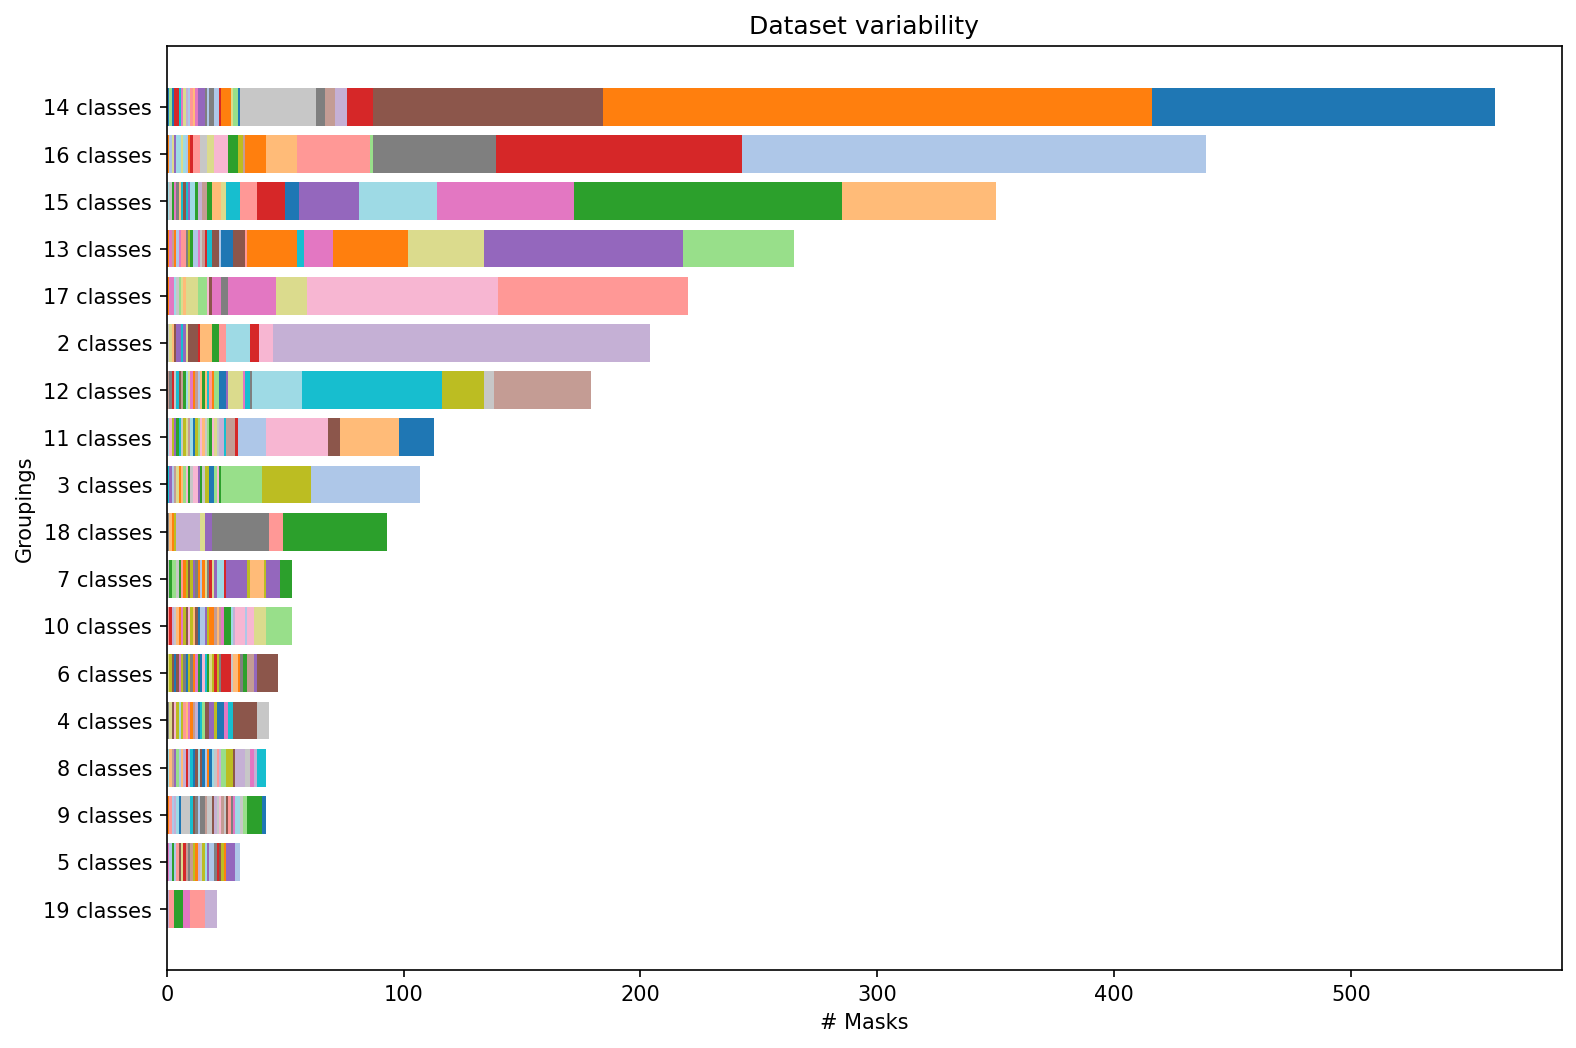

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Supponendo che 'clusters_freq' sia già stato calcolato come nel codice fornito
# Calcolo delle dimensioni di ciascun cluster
dimensioni_cluster = {k: len(v) for k, v in clusters_freq.items() if k[0] != 1}

etichette = []
valori = []

for k, v in dimensioni_cluster.items():
    descrizione = f"{k[0]} classes"
    etichette.append(descrizione)
    valori.append(v)

cluster_labels = [f"{k[0]} classes" for k in dimensioni_cluster.keys()]
frequenze = list(dimensioni_cluster.values())

sorted_indices = np.argsort(frequenze)[::-1]
cluster_labels = [cluster_labels[i] for i in sorted_indices]
frequenze = [frequenze[i] for i in sorted_indices]

plt.figure(figsize=(12, 8), dpi=150)
plt.barh(cluster_labels, frequenze, color=plt.cm.tab20.colors)
plt.xlabel("# Masks")
plt.ylabel("Groupings")
plt.title("Dataset variability")
plt.gca().invert_yaxis()
plt.show()


In [22]:
data = clusters_freq
k1_groups = defaultdict(list)
for (k1, k2), v in data.items():
    k1_groups[k1].append((k2, v))

## Clusters statistics

In [23]:
output = ""
particular_k1_groups = defaultdict(list)
for k1, val in k1_groups.items():
  output += f"# Classes: {k1}\n"
  for v in val:
    nc = [mask_id for mask_id in v[1] if int(labels.iloc[mask_id]) == 0]
    err = [mask_id for mask_id in v[1] if not(int(labels.iloc[mask_id]) == 0 or int(labels.iloc[mask_id]) == 1)]
    if len(err)!=0:
       print("ERRORI")
    perc_notcrit = ((len(nc)/len(v[1])) * 100, len(nc))
    perc_crit = (100 - perc_notcrit[0], len(v[1]) - len(nc))
    if perc_notcrit[0] != 0 and perc_notcrit[0] != 100:
       particular_k1_groups[k1].append((v[0], v[1]))

    output += f"{[cityscapes_labels_dict[i]['name'] for i in v[0]]} : \n\tNON critical perc: {perc_notcrit[0]:.2f}\n\tCritical perc: {perc_crit[0]:.2f}\n"

with open("./statistics.txt", "w") as file:
    file.write(output)

## Clusters visualization

In [24]:
groups = particular_k1_groups

k1_slider = widgets.SelectionSlider(
    options=sorted(groups.keys()),
    description="# Classi presenti",
    style={'description_width': '50px'},
    layout={'width': '500px'}
)

k2_dropdown = widgets.Dropdown(
    options={"Seleziona un valore": ([], [])},
    description="Classi più frequenti",
    style={'description_width': '50px'},
    layout={'width': '300px'}
)

v_slider = widgets.SelectionSlider(
    options=[0],
    value=0,
    description="Mask index",
    style={'description_width': '50px'},
    layout={'width': '500px'}
)

f_slider = widgets.IntSlider(
    value = 0,
    min = 0,
    max = 2,
    step = 1,
    description = "Label filter",
    style={'description_width': '50px'},
    layout={'width': '500px'}
)

def display_mask(n_el, cl, filt, mask_idx):
    frame, fault, _, _, _, mask, _ = fod_dataset[mask_idx]
    print(f"Masks percentage/number with the following characteristics: {len(v_slider.options)/total*100:.2f}/{len(v_slider.options)}")
    plt.figure(figsize=(10, 5))
    plt.imshow(get_color_pallete(mask.cpu().numpy()))
    title = "All Clusters" if filt == 0 else {"Non Critical Clusters" if filt == 1 else "Critical Clusters"}
    plt.title(f"{title} with {n_el} non-zero elements of classes: {[cityscapes_labels_dict[i]['name'] for i in cl[0]]} - Mask {(frame, fault['injection'])}")
    plt.axis('off')
    plt.show()

def update_k2_options(change):
    k1 = change['new']
    k2_options = {str(k2): (k2, v) for k2, v in groups[k1]}
    k2_dropdown.options = k2_options
    if k2_options:
        k2_dropdown.value = list(k2_options.values())[0]
        f_slider.value = 0
    else:
        k2_dropdown.value = None

def filtering_fun(filt):
    if filt == 0:
        def x(val):
            return True
        return  x
    elif filt == 1: # NON CRITICAL MASKS
        def x(val):
            return int(labels.iloc[val]) == 0
        return  x
    elif filt == 2: # CRITICAL MASKS
        def x(val):
            return int(labels.iloc[val]) == 1
        return  x
    else:
        def x(val):
            return False
        return  x

def update_v_slider(change):
    if change['new']:
        if isinstance(change['new'], tuple):
            k2, v = change['new']
        if isinstance(change['new'], int):
            filt = change['new']
            x = filtering_fun(filt)
            v = k2_dropdown.value[1]
            v = list(filter(x, v))
        if v or len(v) != 0:
            v_slider.options = v
            v_slider.value = v[0]
        else:
            v_slider.options = [0]
            v_slider.value = 0

k1_slider.observe(update_k2_options, names='value')
k2_dropdown.observe(update_v_slider, names='value')
f_slider.observe(update_v_slider, names='value')

update_k2_options({'new': k1_slider.value})
update_v_slider({'new': k2_dropdown.value})
update_v_slider({'new': f_slider.value})

ui = VBox([k1_slider, k2_dropdown, f_slider, v_slider])
out = interactive_output(display_mask, {'n_el': k1_slider, 'cl':k2_dropdown, 'filt':f_slider,  'mask_idx': v_slider})

display(ui, out)

Output()